# Project: Write a Data Science Blog Post

In [3]:
# install required packages

import numpy as np 
import pandas as pd 
import os
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Sec A: Business Understanding

Amazon has millions of products sold on its websites and the concerned dataset from Kaggle contains over 10,000 different products at Amazon and its information, customer reviews, etc. The questions I explore are mentioned below:

- Question 1: What are the most popular brands?
- Question 2: What are some keywords that are repeatedly used by brands in descriptions?
- Question 3: Can we predict the amazon categories just using the description?

# Sec B: Data Understanding
    
Access data and get an overview of the uploaded dataset

In [4]:
# read database and store in a dataframe variable
def read(path='./Amazon_Products.csv'):
    df = pd.read_csv(path, dtype=str)
    display(df.head())
    return df

df = read()
df.shape

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,description,...,Unnamed: 885,Unnamed: 886,Unnamed: 887,Unnamed: 888,Unnamed: 889,Unnamed: 890,Unnamed: 891,Unnamed: 892,Unnamed: 893,Unnamed: 894
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,Â£3.42,5Â new,15,1,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Product Description Hornby 2014 Catalogue Box ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuysÂ® Large Christmas Holiday Express Fe...,FunkyBuys,Â£16.99,NaN,2,1,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Size Name:Large FunkyBuysÂ® Large Christmas Ho...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,Â£9.99,2Â new,17,2,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,Â£39.99,NaN,1,2,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,Â£32.19,NaN,3,2,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Product Description Hornby RailRoad 0-4-0 Gild...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(9880, 895)

In [34]:
df.describe()

,price,number_of_reviews,number_of_answered_questions,average_review_rating,category_labels
count,0.0,643.000000,603.000000,643.000000,644.000000
mean,NaN,5.681182,1.792703,4.708865,4.139752
std,NaN,13.161212,2.918918,0.376530,3.344739
min,NaN,1.000000,1.000000,3.600000,1.000000
25%,NaN,1.000000,1.000000,4.400000,1.000000
50%,NaN,2.000000,1.000000,5.000000,4.000000
75%,NaN,4.000000,2.000000,5.000000,6.000000
max,NaN,168.000000,39.000000,5.000000,11.000000


## Sec C: Prepare Data / Data Cleaning

There are a wide variety of columns available in the dataset which will need to be looked at one at a time. Upon a quick look, it seems like most of the columns starting with "Unnamed" are not useful and can be deleted.

In [5]:
# function to summarize any column
def ColSummary (col, dtype=None, new_col=None):
    try:
        print("\n"+str(col).upper()+" ANALYSIS")
        if new_col:
            df.rename(columns={col:new_col})
            print("\t"+col+" name updated to "+new_col)
            col = new_col
        if dtype:
            df[col] = df[col].astype(dtype)
            print("\tType changed to "+dtype)
        print('\tTotal number of values : ', len(df[col]))
        print('\tTotal number of unique values : ', df[col].nunique())
        print('\tUnique values : ',df[col].unique()[:5])
        print('\tRange of length : ', min(df[col].apply(lambda x: len(str(x))))," to ",max(df[col].apply(lambda x: len(str(x)))))
        print('\tMissing Values : ', df[col].isna().sum())
    except:
        print("\n*** Cannot work with this datatype.. Try Again.... ***")

In [6]:
# delete columns which are unnamed
unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
df = df.drop(unnamed_cols, axis = 1)
print("Leftover columns: ", df.columns)

Leftover columns:  Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category', 'description',
       'product_information', 'product_description',
       'items_customers_buy_after_viewing_this_item',
       'customer_questions_and_answers'],
      dtype='object')


In [7]:
# Analyze and clean Unique IDS (primary key)
ColSummary('uniq_id', 'str')
# Some IDs have unusual length
print('\n\tInspecting IDs with unusual length : ', list(df['uniq_id'][df['uniq_id'].apply(lambda x: len(str(x)))<=3]))
print('\tDeleting IDs with unusual length ..... ')
df = df.drop(index = list(df['uniq_id'][df['uniq_id'].apply(lambda x: len(str(x))<=3)].index))
print('\nUnique IDs updated .....')
ColSummary('uniq_id')


UNIQ_ID ANALYSIS
	Type changed to str
	Total number of values :  9880
	Total number of unique values :  6253
	Unique values :  ['eac7efa5dbd3d667f26eb3d3ab504464' 'b17540ef7e86e461d37f3ae58b7b72ac'
 '348f344247b0c1a935b1223072ef9d8a' 'e12b92dbb8eaee78b22965d2a9bbbd9f'
 'e33a9adeed5f36840ccc227db4682a36']
	Range of length :  1  to  32
	Missing Values :  0

	Inspecting IDs with unusual length :  ['nan', 'nan', '}', 'nan', 'nan', '}', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na

In [8]:
# Analyze Product Name - No cleaning required
ColSummary('product_name', 'string')


PRODUCT_NAME ANALYSIS
	Type changed to string
	Total number of values :  6251
	Total number of unique values :  6236
	Unique values :  <StringArray>
[                                                                                                  'Hornby 2014 Catalogue',
 'FunkyBuysÂ® Large Christmas Holiday Express Festive Train Set (SI-TY1017) Toy Light / Sounds / Battery Operated & Smoke',
                                              'CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT ENGINE BOXED BOYS KIDS BATTERY',
                                                                          'HORNBY Coach R4410A BR Hawksworth Corridor 3rd',
                                                         'Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam Locomotive Model']
Length: 5, dtype: string
	Range of length :  4  to  536
	Missing Values :  0


In [9]:
# Analyze Manufacturer - No cleaning required
ColSummary('manufacturer', 'string') 


MANUFACTURER ANALYSIS
	Type changed to string
	Total number of values :  6251
	Total number of unique values :  1948
	Unique values :  <StringArray>
['Hornby', 'FunkyBuys', 'ccf', 'Generic', 'Chuggington']
Length: 5, dtype: string
	Range of length :  1  to  48
	Missing Values :  5


In [10]:
# Analyze Price - Need to convert string to numeric
ColSummary('price')

# Some rows have range mentioned instead of a price - this is significantly changing the df size
# another way to tackle this would be to add the middle point of the range as the price
print("\n Deleting rows which have price with greater than 5 length i.e. have ranges instead of values .....")
df = df.drop(index = list(df['price'][df['price'].apply(lambda x: len(str(x))>5)].index))

# Remove the euro sign before numeric conversion
df['price'] = df['price'][df['price'].isna()==False].str[1:]

# Convert into float and analyze updated column
ColSummary('price', 'float64')


PRICE ANALYSIS
	Total number of values :  6251
	Total number of unique values :  1988
	Unique values :  ['Â£3.42' 'Â£16.99' 'Â£9.99' 'Â£39.99' 'Â£32.19']
	Range of length :  3  to  21
	Missing Values :  859

 Deleting rows which have price with greater than 5 length i.e. have ranges instead of values .....

PRICE ANALYSIS
	Type changed to float64
	Total number of values :  859
	Total number of unique values :  0
	Unique values :  [nan]
	Range of length :  3  to  3
	Missing Values :  859


In [11]:
# Analyze Number available in stock - need to change to numeric 
ColSummary('number_available_in_stock')

# split the stings into list and keep only the numeric part
df['number_available_in_stock'] = df['number_available_in_stock'].apply(lambda x: str(x).split()[0])

# change to float and analyze again
ColSummary('number_available_in_stock','float64')


NUMBER_AVAILABLE_IN_STOCK ANALYSIS
	Total number of values :  859
	Total number of unique values :  38
	Unique values :  ['1Â\xa0new' '18Â\xa0new' '12Â\xa0new' '2Â\xa0new' '1Â\xa0used']
	Range of length :  3  to  14
	Missing Values :  184

NUMBER_AVAILABLE_IN_STOCK ANALYSIS

*** Cannot work with this datatype.. Try Again.... ***


In [12]:
# Analyze Number of Reviews - need to convert into numeric
ColSummary('number_of_reviews')

# some strings have commas which is preventing direct float conversion
print("\n Removing commas from strings for float conversion .....")
df['number_of_reviews'] = df['number_of_reviews'].apply(lambda x: str(x).replace(',',''))

# convert to float and analyze updated columns
ColSummary('number_of_reviews', 'float64')


NUMBER_OF_REVIEWS ANALYSIS
	Total number of values :  859
	Total number of unique values :  54
	Unique values :  ['8' '1' '2' '21' '4']
	Range of length :  1  to  3
	Missing Values :  2

 Removing commas from strings for float conversion .....

NUMBER_OF_REVIEWS ANALYSIS
	Type changed to float64
	Total number of values :  859
	Total number of unique values :  54
	Unique values :  [ 8.  1.  2. 21.  4.]
	Range of length :  3  to  5
	Missing Values :  2


In [13]:
# Analyze Number of Answered Questions - need to convert into numeric
ColSummary('number_of_answered_questions','float64')


NUMBER_OF_ANSWERED_QUESTIONS ANALYSIS
	Type changed to float64
	Total number of values :  859
	Total number of unique values :  15
	Unique values :  [ 1.  2.  6. nan  4.]
	Range of length :  3  to  4
	Missing Values :  55


In [14]:
# Analyze Avg Review Ratign - need to convert into numeric
ColSummary('average_review_rating')

# the values include the denominator of the rating which is consistent throughtout and hence, need not be mentioned
df['average_review_rating'] = df['average_review_rating'].apply(lambda x: str(x).split()[0])

# After retaining only ratings and removing additional text, convert into float
ColSummary('average_review_rating', 'float64')


AVERAGE_REVIEW_RATING ANALYSIS
	Total number of values :  859
	Total number of unique values :  14
	Unique values :  ['4.8 out of 5 stars' '5.0 out of 5 stars' '4.5 out of 5 stars'
 '4.0 out of 5 stars' '4.3 out of 5 stars']
	Range of length :  3  to  18
	Missing Values :  2

AVERAGE_REVIEW_RATING ANALYSIS
	Type changed to float64
	Total number of values :  859
	Total number of unique values :  14
	Unique values :  [4.8 5.  4.5 4.  4.3]
	Range of length :  3  to  3
	Missing Values :  2


In [15]:
# Analyze Categories - Each value has all the subcatogories mentioned in a string format - need to convert to list
ColSummary('amazon_category_and_sub_category')

# break using delimiter for list conversion
df['amazon_category_and_sub_category'] = df['amazon_category_and_sub_category'].apply(lambda x: str(x).split(" > "))

# each list has varied length, for easier analysis - make len consistent by adding None
itr = max(df['amazon_category_and_sub_category'].apply(lambda x: len(x)))
for i in range (1, itr+1):
    df['amazon_category_and_sub_category'].apply(lambda x: x.append("None") if (len(x) < i) else x)

# Analyze updated column
ColSummary('amazon_category_and_sub_category')


AMAZON_CATEGORY_AND_SUB_CATEGORY ANALYSIS
	Total number of values :  859
	Total number of unique values :  95
	Unique values :  ['Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains'
 'Hobbies > Model Trains & Railway Sets > Rail Vehicles > Locomotives'
 'Hobbies > Model Trains & Railway Sets > Lighting & Signal Engineering > Lamps & Lighting'
 'Hobbies > Model Trains & Railway Sets > Accessories > Recreational Activities'
 'Characters & Brands > Thomas & Friends > Train Play > Wooden Thomas']
	Range of length :  3  to  90
	Missing Values :  123

AMAZON_CATEGORY_AND_SUB_CATEGORY ANALYSIS
	Total number of values :  859

*** Cannot work with this datatype.. Try Again.... ***


In [16]:
# Analyze description - no change required
ColSummary('description')


DESCRIPTION ANALYSIS
	Total number of values :  859
	Total number of unique values :  767
	Unique values :  ['Product Description An amazingly Interactive Chuggington World! Chuggington Interactive Chatsworth instantly recognises and "magically" talks to any other engine, training stop and set accessories. This engine has over 60 sounds and phrases (when used with other Chuggington interactive products). Featuring the actual voice from the Chuggington show. Each Interactive talking engine features Smart Talk technology which enables them to instantly recognise any other engine, react to any train stop and respond to your play! Chuggington Interactive is a magical open ended play system featuring iconic destinations and characters from the BBC\'s CBeebies top rated preschool show Chuggington. Chatsworth is a very proper engine who lives next door to Harrison in the upper level of the roundhouse. Chatsworth is honest, good mannered, polite and considerate of others, however he considers

In [17]:
# Analyze Product Information - no change required
ColSummary('product_information')


PRODUCT_INFORMATION ANALYSIS
	Total number of values :  859
	Total number of unique values :  855
	Unique values :  ["Technical Details Item Weight150 g Product Dimensions12.7 x 4.4 x 6.7 cm Batteries:2 AA batteries required. (included) Manufacturer recommended age:36 months - 10 years Item model numberLC55012 Manufacturer's Suggested Maximum Weight43.5 Kilograms Number of Puzzle Pieces1 Assembly RequiredNo Batteries Required?Yes Batteries Included?Yes Material Type(s)Plastic Material Composition100% plastic Material Care InstructionsInteraction performance may be reduced with use in an outdoor environment or in direct sunlight Remote Control Included?No Radio Control SuitabilityIndoor Colormulticoloured Â\xa0Â\xa0 Additional Information ASINB003M2XTK6 Best Sellers Rank 195,658 in Toys & Games (See top 100) #307 inÂ\xa0Toys & Games > Model Trains & Railway Sets > Rail Vehicles > Trains Shipping Weight227 g Delivery Destinations:Visit the Delivery Destinations Help page to see where th

In [18]:
# Analyze Product Description - no change required

# the values look similar to description column - this column might not add much value 
ColSummary('product_description')


PRODUCT_DESCRIPTION ANALYSIS
	Total number of values :  859
	Total number of unique values :  766
	Unique values :  ['Product Description An amazingly Interactive Chuggington World! Chuggington Interactive Chatsworth instantly recognises and "magically" talks to any other engine, training stop and set accessories. This engine has over 60 sounds and phrases (when used with other Chuggington interactive products). Featuring the actual voice from the Chuggington show. Each Interactive talking engine features Smart Talk technology which enables them to instantly recognise any other engine, react to any train stop and respond to your play! Chuggington Interactive is a magical open ended play system featuring iconic destinations and characters from the BBC\'s CBeebies top rated preschool show Chuggington. Chatsworth is a very proper engine who lives next door to Harrison in the upper level of the roundhouse. Chatsworth is honest, good mannered, polite and considerate of others, however he c

In [19]:
# Analyze URLs of the next bought product 

ColSummary('items_customers_buy_after_viewing_this_item')


ITEMS_CUSTOMERS_BUY_AFTER_VIEWING_THIS_ITEM ANALYSIS
	Total number of values :  859
	Total number of unique values :  593
	Unique values :  ['http://www.amazon.co.uk/Chuggington | http://www.amazon.co.uk/Learning-Chuggington | http://www.amazon.co.uk/Chuggington | http://www.amazon.co.uk/Learning-Curve-Chuggington'
 nan
 'http://www.amazon.co.uk/Glacier-Express-Basic-3-Car-Model/dp/B009M019XG | http://www.amazon.co.uk/Glacier-Express-Add-On-4-Car-Model/dp/B009M019R2 | http://www.amazon.co.uk/Peco-Gauge-Starter-Track-Set/dp/B000VKCCVY | http://www.amazon.co.uk/Peco-Shows-You-How-Booklet/dp/B002QVFD3A'
 'http://www.amazon.co.uk/Power-Trains-Auto-Loader-City/dp/B007T4KQ40 | http://www.amazon.co.uk/Power-Trains-Action-Accessories | http://www.amazon.co.uk/Power-Trains-Oval-Track-Pack/dp/B007T4KP7S | http://www.amazon.co.uk/Power-City-Trains-Starter-Set/dp/B00L4PMC2O'
 'http://www.amazon.co.uk/Chuggington | http://www.amazon.co.uk/Chuggington | http://www.amazon.co.uk/Chuggington | http://

In [20]:
# Analyze customer Qs 
ColSummary('customer_questions_and_answers')

# There are a lot of missing values in this column
# This is not unusual as customers might not have questions about each product


CUSTOMER_QUESTIONS_AND_ANSWERS ANALYSIS
	Total number of values :  859
	Total number of unique values :  53
	Unique values :  [nan
 'what is the difference between this model and the Green model for 14 plus age group // Hi,  Apart from some minor detailing I believe their is very little difference.                             Regards John,, Shop Amazon Ltd'
 'is it DCC // It is not DCC i.e. it does not have a 6 pin DCC socket so a wired DCC decoder will need to be fitted.  http://sumidacrossing.org/Collection/ This link provides information on many JR locos'
 'Hi just a query about the Super Boggle, is that a picture of the actual box it looks immaculate if it is as i want to give as present // I am not selling this, but when I ordered a used version of Boggle for a gift, the box was in very good condition with just a dent in one corner.'
 'I have broken crosswords timer. How long is it? // I have no idea but will run mine and time it and let you know']
	Range of length :  3  to  2002

In [21]:
# Final df shape after cleaning
df.shape

(859, 14)

# Sec D: Evaluation


<font color = 'blue'>
<h2> Question 1. What are the most popular brands? </h2>

There are multiple ways to define "popular". I'm going to explore 3 ways here:
<ul>
    <li>Number of products sold</li>
<li>Total sales by price </li>
<li>Highest rated products </li>
    </ul>

In [22]:
# number of products sold

df[['product_name','manufacturer']].groupby('manufacturer').count().sort_values(by = "product_name", ascending = False)

,product_name
manufacturer,
PokÃ©mon,28
LEGO,20
Scalextric,20
Mattel,19
Disney,18
...,...
Houdini Magic Boxes,1
Horizon Hobby,1
Hobby,1


In [23]:
# Total sales by price

df[['price','manufacturer']].groupby('manufacturer').sum().sort_values(by = "price", ascending = False)

,price
manufacturer,
13,0.0
SAC,0.0
ShalinIndia,0.0
Sevi,0.0
Seasonal,0.0
...,...
Green,0.0
Great Gifts,0.0
Great Eastern Entertainment,0.0


In [24]:
# highest rated

ratings_df = df[['average_review_rating', 'number_of_reviews','manufacturer']].groupby('manufacturer').agg({'average_review_rating':'mean', 'number_of_reviews': "sum"
                                                                                      }).sort_values(by = ["average_review_rating","number_of_reviews"], ascending = False)
ratings_df

,average_review_rating,number_of_reviews
manufacturer,,
Fisher-Price,5.0,20.0
Teddy Hermann,5.0,12.0
BSP,5.0,11.0
Cheatwell Games,5.0,8.0
Tamiya,5.0,8.0
...,...,...
Yu-gi-oh!,4.0,1.0
YuGIOH,4.0,1.0
basetoys,4.0,1.0


In [25]:
# checking number of manufacturers with 5 rating
print("\n Brands with perfect 5 rating:", len(ratings_df[ratings_df["average_review_rating"]==5.0]))

# checking number of 5-rated manufactureres which have > 5 number of reviews      
print("\n Brands with perfect 5 rating and substantial number of reviews:",
      len(ratings_df[ratings_df["average_review_rating"]==5.0][ratings_df[ratings_df["average_review_rating"]==5.0]
                                                               ["number_of_reviews"]>5]),"\n\n")


 Brands with perfect 5 rating: 198

 Brands with perfect 5 rating and substantial number of reviews: 12 




<font color = 'blue'>
    <h3> Based on the above visualizations: </h3>

- Oxford Diecast, Disney and MyTinyWorld have sold the most products
- Oxfort Diecast has had the highest sales by far almost double the second highest
- 669 manufacturers have perfect 5 rating but only 22 have been rated 5 on average by 5 or more customers

***

In [ ]:
Question 2
        Analyse
        Visualise
        Brief explanation for visualisation


<font color = 'blue'>
<h2> Question 2. What are some keywords that are repeatedly used by brands in descriptions? </h2> 

    To evaluate the words marketing / product teams are using to attract customers, we can do a word frequency analysis. A simple way to do this is to create a word-cloud which can be done using an existing library. We can input the following functionalities in the in-build function:
- stopwords: words like "a", "the", are repeated a lot in a sentence but won't be able to give any meaningful insights. Hence, we can eliminate such stopwords from our analysis
- mask: be default, the word cloud is in a circular shape, but we can change that using mask
- max_words: maximum words to be shown in a word-cloud
- max_font_size: maximum font size of the most used word

In [28]:
def show_wordcloud(data, title = None):
    stopwords = set(STOPWORDS)
    mask = np.array(Image.open("./amazon.png"))
    wordcloud = WordCloud(
        background_color='white',
        stopwords = stopwords,
        mask = mask,
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(25, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

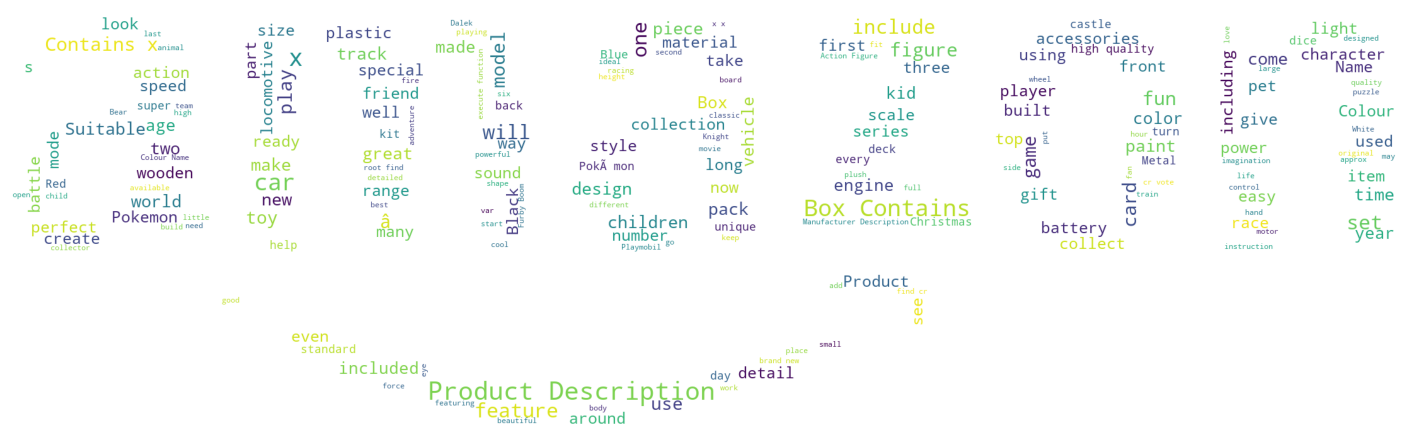

In [29]:
col = 'description'
wordcloud_df = df[df[col].notna()]
show_wordcloud(wordcloud_df[col].values)

<font color = 'blue'>
    <h3> Based on the above visualization </h3>

Some interesting words repeated across descriptions are: Suitable, high quality, classic, great, feature, card

***

<font color = 'blue'>
<h2> Question 3. Can we predict the amazon categories just using the description? </h2>
    
    I wanted to see how related the description is with the main amazon category, so I built a model to do just that. There are 3 description columns available in the dataset - description, product description and product information. The first 2 columns are pretty similar so I just used one of them; and I created another model with product information so that I can compare these 2 models.

In [30]:
def TextClassifier(text_data,label):
    "function to create text classifier for a set of data and labels"
    text_clf = Pipeline([ ('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
    text_clf = text_clf.fit(text_data, label)
    return text_clf

In [31]:
# defining the target variable

df['category'] = df['amazon_category_and_sub_category'].apply(lambda x: x[0])

categorytolabel = {}
i = 1
for item in df['category'].unique():
    categorytolabel[item] = i
    i = i+1

df['category_labels'] = df['category'].map(categorytolabel)

df = df.groupby('category').filter(lambda x : len(x)>30)
df = df.drop(index = list(df[df['category']=='nan'].index))

In [32]:
# running the model and comparing the predictions
text_df = df[['product_information','product_description']]

for col in text_df.columns:
    text_df[col] = text_df[col].fillna(value='None')
    model = TextClassifier(text_df[col],df['category_labels'])
    text_df[col+'_classification'] = model.predict(text_df[col])

text_df['product_information_classification'] = text_df['product_information_classification'].map({value : key for (key, value) in categorytolabel.items()})
text_df['product_description_classification'] = text_df['product_description_classification'].map({value : key for (key, value) in categorytolabel.items()})
df = df.merge(text_df[['product_information_classification','product_description_classification']], how = 'left', left_index = True, right_index = True)


from sklearn.metrics import classification_report
print("\n\n ********* CLASSIFICATION ACCURACY BASED ON PRODUCT INFORMATION *********")
print("\n", classification_report(df['category'], df['product_information_classification'] ))
print("\n\n ********* CLASSIFICATION ACCURACY BASED ON PRODUCT DESCRIPTION *********")
print("\n", classification_report(df['category'], df['product_description_classification'] ))



 ********* CLASSIFICATION ACCURACY BASED ON PRODUCT INFORMATION *********

                          precision    recall  f1-score   support

          Arts & Crafts       0.00      0.00      0.00        36
    Characters & Brands       0.00      0.00      0.00        79
Die-Cast & Toy Vehicles       0.00      0.00      0.00        95
            Fancy Dress       0.00      0.00      0.00        41
     Figures & Playsets       1.00      0.01      0.02        82
                  Games       0.00      0.00      0.00        73
                Hobbies       0.37      1.00      0.54       238

               accuracy                           0.37       644
              macro avg       0.20      0.14      0.08       644
           weighted avg       0.26      0.37      0.20       644



 ********* CLASSIFICATION ACCURACY BASED ON PRODUCT DESCRIPTION *********

                          precision    recall  f1-score   support

          Arts & Crafts       1.00      0.06      0.11      

<font color = "blue">
<h3>Based on the above results:</h3>
Product Description is a better predictor of amazon category compared to product information

***